In [1]:
import anndata
import numpy as np
import scvelo as scv
import scipy as sp
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

sys.path.append('../')
import velovae as vv

In [2]:
figure_path = '../figures/Pancreas/Rho'
model_path = '../checkpoints/Pancreas/Rho'
data_path = '../data/Pancreas/Rho'
#data_path = '/scratch/blaauw_root/blaauw1/gyichen'
adata = anndata.read_h5ad(data_path+'/output_vanillapp.h5ad')
key = 'vanillapp'
adata.obsm['vanillapp_z'].shape

(3696, 4)

In [3]:
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'lime', 'grey', \
   'olive', 'cyan', 'pink', 'gold', 'steelblue', 'salmon', 'teal', \
   'magenta', 'rosybrown', 'darkorange', 'yellow', 'greenyellow', 'darkseagreen', 'yellowgreen', 'palegreen', \
   'hotpink', 'navajowhite', 'aqua', 'navy', 'saddlebrown', 'black', 'maroon']

# Compare ODE Parameters

In [ ]:
#alpha_scv, beta_scv, gamma_scv = adata.var['fit_alpha'].to_numpy(), adata.var['fit_beta'].to_numpy(), adata.var['fit_gamma'].to_numpy()
#scaling = adata.var['fit_scaling'].to_numpy()
#beta_scv *= scaling
#alpha, beta, gamma = adata.var['vanilla_alpha'].to_numpy(), adata.var['vanilla_beta'].to_numpy(), adata.var['vanilla_gamma'].to_numpy()
alpha_pp, beta_pp, gamma_pp = adata.var['vanillapp_alpha'].to_numpy(), adata.var['vanillapp_beta'].to_numpy(), adata.var['vanillapp_gamma'].to_numpy()
t0 = adata.layers['vanillapp_t0']
u0 = adata.layers['vanillapp_u0']
s0 = adata.layers['vanillapp_s0']
rho = adata.layers['vanillapp_rho']
z = adata.obsm['vanillapp_z']
z.shape

In [ ]:
gidx = np.where(adata.var_names=='March4')[0][0]
print(adata.var_names[gidx])
print(f'scvelo\t{alpha_scv[gidx]:.3f}, {beta_scv[gidx]:.3f}, {gamma_scv[gidx]:.3f}')
print(f'VAE\t{alpha[gidx]:.3f}, {beta[gidx]:.3f}, {gamma[gidx]:.3f}')
print(f'rho-VAE\t{alpha_pp[gidx]:.3f}, {beta_pp[gidx]:.3f}, {gamma_pp[gidx]:.3f}')

In [ ]:
fig, ax = plt.subplots(3,1,figsize=(8,6))
bins = np.linspace(0,5,51)
ax[0].hist(beta_scv/gamma_scv, bins, alpha=0.3, label='scvelo')
ax[0].set_title('scvelo')
ax[1].hist(beta/gamma, bins, alpha=0.3, label='VAE')
ax[1].set_title('VAE')
ax[2].hist(beta_pp/gamma_pp, bins, alpha=0.3, label='rho-VAE')
ax[2].set_title('rho-VAE')
plt.tight_layout()
fig.show()
fig.savefig(figure_path+f'/betagamma.png', bbox_inches='tight')

In [ ]:
methods = ['scvelo','vanilla']
keys = ['fit','vanilla']
genes=['Cpe','Dcdc2a','Pcsk2','Ppp3ca']
plot_type = ['signal', 'time', 'type']
grid_size = (2,2)

In [ ]:
vv.postAnalysis(adata, methods, keys, genes, plot_type, Nplot=500, embed="umap", grid_size=grid_size, save_path=figure_path)

In [ ]:
#V, U, S = vv.rnaVelocityVanilla(adata, 'vanilla', use_raw=False, use_scv_genes=False)
#V, U, S = vv.rnaVelocityBranch(adata, key, use_raw=False, use_scv_genes=False)
V, U, S = vv.rnaVelocityRhoVAE(adata, key, use_raw=False, use_scv_genes=False)

In [ ]:
cell_labels = adata.obs.clusters
cell_types = np.unique(cell_labels)

In [ ]:
np.convolve([1,2,3], [0.2,0.8])

In [ ]:
name='Smoc1'
gidx = np.where(adata.var_names==name)[0][0]
#gidx = 862
name = adata.var_names[gidx]
v = V[:, gidx]
u = U[:, gidx]
s = S[:, gidx]
t = adata.obs[f"vanillapp_time"].to_numpy()
dt = 1.0
s_ = s + v*dt
print(np.sum(s_-s<0))
fig, ax = plt.subplots()
#ax.plot(t, s, '.', label='s')
#ax.plot(t, s_, '.', label='s+v*dt')
for i,x in enumerate(cell_types):
    ax.quiver(t[cell_labels==x][::10], s[cell_labels==x][::10], dt*np.ones((len(t[cell_labels==x][::10]))), v[cell_labels==x][::10]*dt, angles='xy', scale=3.0, scale_units='inches', headwidth=5.0, headlength=8.0, color=colors[i], label=x)
ax.set_title(name)
ax.legend(bbox_to_anchor=(1.05,1.0), loc='upper left')
fig.show()
fig.savefig(figure_path+f'/{name}_{key}_vel.png', bbox_inches='tight')

In [ ]:
uhat, shat = U[:, gidx], S[:, gidx]
u, s = adata.layers['Mu'][:,gidx].squeeze(), adata.layers['Ms'][:,gidx].squeeze()
scaling = adata.var.vanillapp_scaling[gidx]
fig, ax = plt.subplots(5,1,figsize=(12,15))
L = 50
for i,x in enumerate((cell_types)):
    ax[0].plot(t[cell_labels==x], u[cell_labels==x]/scaling, '.', color=colors[i])
    ax[1].plot(t[cell_labels==x], s[cell_labels==x], '.', color=colors[i])
    ax[2].plot(t[cell_labels==x], rho[cell_labels==x, gidx], '.', color=colors[i])
    t0_, u0_, s0_ = t0[cell_labels==x,gidx], u0[cell_labels==x,gidx],s0[cell_labels==x,gidx]
    idx_order = np.argsort(t0_)
    l = min(L,len(t0_))
    u0_ = np.convolve(u0_[idx_order], np.ones((l))/l,'same')
    s0_ = np.convolve(s0_[idx_order], np.ones((l))/l,'same')
    ax[3].plot(t0_[idx_order], u0_, '-', color=colors[i])
    ax[4].plot(t0_[idx_order], s0_, '-', color=colors[i])

ax[0].set_xlim(t.min(), t.max())
ax[1].set_xlim(t.min(), t.max())
ax[2].set_xlim(t.min(), t.max())
ax[3].set_xlim(t.min(), t.max())
ax[4].set_xlim(t.min(), t.max())
#ax[3].set_ylim(0, u.max())
#ax[4].set_ylim(0, s.max())
ax[0].set_ylabel('U', fontsize=15, rotation=0)
ax[1].set_ylabel('S', fontsize=15, rotation=0)
ax[2].set_ylabel(r'$\rho$', fontsize=15, rotation=0)
ax[3].set_ylabel('u0', fontsize=15, rotation=0)
ax[4].set_ylabel('s0', fontsize=15, rotation=0)
fig.suptitle(adata.var_names[gidx])
plt.tight_layout()
fig.show()
fig.savefig(figure_path+f'/rho_{adata.var_names[gidx]}.png')

In [ ]:
vx, vy, P = vv.rnaVelocityEmbed(adata, 'vanilla')
vx = np.clip(vx, vx.mean()-3*vx.std(), vx.mean()+3*vx.std())
vy = np.clip(vy, vy.mean()-3*vy.std(), vy.mean()+3*vy.std())

In [ ]:
#scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata, vkey=f'{key}_velocity')
scv.tl.velocity_embedding(adata, vkey=f'{key}_velocity')
scv.pl.velocity_embedding_stream(adata, vkey=f'{key}_velocity', figsize=(8,6), save=figure_path+f'/brain_{key}vel.png')

# Alternative Method
This is a verification of a proposed method to learn better velocity.
## Step 1. Load data

In [4]:
alpha, beta, gamma = adata.var['vanillapp_alpha'].to_numpy(), adata.var['vanillapp_beta'].to_numpy(), adata.var['vanillapp_gamma'].to_numpy()
scaling = adata.var['vanillapp_scaling'].to_numpy()
ton = adata.var['vanillapp_ton'].to_numpy()
toff = adata.var['vanillapp_toff'].to_numpy()

rho = adata.layers['vanillapp_rho']
z = adata.obsm['vanillapp_z']
t = adata.obs.vanillapp_time.to_numpy()
sigma_u, sigma_s = adata.var.vanillapp_sigma_u.to_numpy(), adata.var.vanillapp_sigma_s.to_numpy()

## Step 2. Find KNN as the initial condition

In [5]:
def knnX0(U, S, t, z, dt, k):
    N = len(t)
    u0 = np.zeros(U.shape)
    s0 = np.zeros(S.shape)
    t0 = np.ones((N))*t.min()
    
    order_idx = np.argsort(t)
    _t = t[order_idx]
    _z = z[order_idx]
    _U = U[order_idx]
    _S = S[order_idx]
    
    knn = np.ones((N,k))*np.nan
    D = np.ones((N,k))*np.nan
    ptr = 0
    left, right = 0, 0
    i = 0
    while(left<N): #i as initial point x0
        #Update left, right
        if(_t[i]+dt[0]>=_t[-1]):
            break;
        for l in range(left, N):
            if(_t[l]>=_t[i]+dt[0]):
                left = l
                break
        for l in range(right, N):
            if(_t[l]>=_t[i]+dt[1]):
                right = l
                break
        
        #Update KNN
        for j in range(left, right): #j is the set of cell with i in the range [tj-dt,tj-dt/2]
            dist = np.linalg.norm(z[i]-z[j])
            pos_zero = np.where(np.isnan(knn[j]))[0]
            if(len(pos_zero)>0): #there hasn't been k nearest neighbors for j yet
                knn[j,pos_zero[0]] = i
                D[j,pos_zero[0]] = dist
            else:
                idx_smallest = np.argmin(D[j])
                if(dist<D[j,idx_smallest]):
                    D[j,idx_smallest] = dist
                    knn[j,idx_smallest] = i
        i += 1
    #Calculate initial time and conditions
    for i in range(N):
        if(np.all(np.isnan(knn[i]))):
            continue
        pos = np.where(~np.isnan(knn[i]))[0]
        u0[order_idx[i]] = _U[knn[i,pos].astype(int)].mean(0)
        s0[order_idx[i]] = _S[knn[i,pos].astype(int)].mean(0)
        t0[order_idx[i]] = _t[knn[i,pos].astype(int)].mean()
    return u0,s0,t0,knn

In [6]:
u0, s0, t0, knn = knnX0(adata.layers['Mu'],adata.layers['Ms'],t,z,[1.2, 1.5],20)

## Step 2. Create optimizer and parameters

In [7]:
device = torch.device('cpu')
alpha_ts = torch.tensor(np.log(alpha), device=device, requires_grad=True)
beta_ts = torch.tensor(np.log(beta), device=device, requires_grad=True)
gamma_ts = torch.tensor(np.log(gamma), device=device, requires_grad=True)
rho_ts = torch.tensor(-np.log(1/rho-1+1e-10), device=device, requires_grad=True)
#rho_ts = torch.tensor(np.zeros((adata.n_obs,adata.n_vars)), device=device, requires_grad=True)
ton_ts = torch.tensor(ton, requires_grad=False).to(device)
toff_ts = torch.tensor(toff, requires_grad=False).to(device)
t0_ts = torch.tensor(t0.reshape(-1,1), requires_grad=False).to(device)
u0_ts = torch.tensor(u0, requires_grad=False).to(device)
s0_ts = torch.tensor(s0, requires_grad=False).to(device)
sigma_u_ts = torch.tensor(sigma_u, requires_grad=False).to(device)
sigma_s_ts = torch.tensor(sigma_s, requires_grad=False).to(device)
scaling_ts = torch.tensor(scaling, requires_grad=False).to(device)

t_ts = torch.tensor(t.reshape(-1,1), requires_grad=False).to(device)


In [ ]:
lr = 1e-3
param_ode = [alpha_ts, beta_ts, gamma_ts, rho_ts]
optimizer = torch.optim.Adam(param_ode, lr=lr)

## Step 3. Training

In [ ]:
from torch.utils.data import Dataset
class SCData(Dataset):
    """
    This is a simple pytorch dataset class for batch training.
    Each sample represents a cell. Each dimension represents a single gene.
    """
    def __init__(self, D):
        """
        D: [N x G] cell by gene data matrix
        weight: (optional) [N x 1] training weight of each sample
        """
        self.M, self.N = D.shape[0], D.shape[1]//2
        self.data = D
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], idx
B = 128
dataset = SCData(np.concatenate((adata.layers['Mu'],adata.layers['Ms']),1))
data_loader = torch.utils.data.DataLoader(dataset, batch_size=B, shuffle=True)

In [8]:
def predSU(tau, u0, s0, alpha, beta, gamma, scaling):
    """
    (PyTorch Version)
    Analytical solution of the ODE
    
    tau: [B x 1] or [B x 1 x 1] time duration starting from the switch-on time of each gene.
    u0, s0: [G] or [N type x G] initial conditions
    alpha, beta, gamma: [G] or [N type x G] generation, splicing and degradation rates
    """
    expb, expg = torch.exp(-beta*tau), torch.exp(-gamma*tau)
    unstability = (torch.abs(beta-gamma) < 1e-3).long()
    eps = 1e-6
    
    upred = u0*expb+alpha/beta*(1-expb)
    spred = s0*expg+alpha/gamma*(1-expg)+(alpha-beta*u0)/(gamma-beta+eps)*(expg-expb)*(1-unstability)+(alpha-beta*u0)*tau*expg*unstability
    return nn.functional.relu(upred)*scaling, nn.functional.relu(spred)

def predSteady(tau_s, alpha, beta, gamma):
    """
    (PyTorch Version)
    Predict the steady states.
    tau_s: [G] time duration from ton to toff
    alpha, beta, gamma: [G] generation, splicing and degradation rates
    """
    unstability = (torch.abs(beta - gamma) < 1e-3).long()
    eps = 1e-6
    
    expb, expg = torch.exp(-beta*tau_s), torch.exp(-gamma*tau_s)
    u0 = alpha/(beta+eps)*(torch.tensor([1.0]).to(alpha.device)-expb)
    s0 = alpha/(gamma+eps)*(torch.tensor([1.0]).to(alpha.device)-expg)+alpha/(gamma-beta+eps)*(expg-expb)*(1-unstability)+alpha*tau_s*expg*unstability
    
    return u0,s0

def ode(t,alpha,beta,gamma,to,ts,train_mode=False,neg_slope=0):
    """
    (PyTorch Version)
    ODE Solution
    
    t: [B x 1] cell time
    alpha, beta, gamma: [G] generation, splicing and degradation rates
    to, ts: [G] switch-on and -off time
    """
    unstability = (torch.abs(beta - gamma) < 1e-3).long()
    eps = 1e-6
    o = (t<=ts).int()
    
    #Induction
    tau_on = nn.functional.leaky_relu(t-to, negative_slope=neg_slope) if train_mode else nn.functional.relu(t-to) 
    expb, expg = torch.exp(-beta*tau_on), torch.exp(-gamma*tau_on)
    uhat_on = alpha/(beta+eps)*(torch.tensor([1.0]).to(alpha.device)-expb)
    shat_on = alpha/(gamma+eps)*(torch.tensor([1.0]).to(alpha.device)-expg)+ (alpha/(gamma-beta+eps)*(expg-expb)*(1-unstability) + alpha*tau_on*expg * unstability)
    
    assert not torch.any(torch.isnan(uhat_on))
    assert not torch.any(torch.isnan(shat_on))
    
    #Repression
    u0_,s0_ = predSteady(nn.functional.leaky_relu(ts-to, neg_slope),alpha,beta,gamma) if train_mode else predSteady(nn.functional.relu(ts-to),alpha,beta,gamma)  
    assert not torch.any(torch.isnan(u0_))
    assert not torch.any(torch.isnan(s0_))
    tau_off = nn.functional.leaky_relu(t-ts, negative_slope=neg_slope) if train_mode else nn.functional.relu(t-ts) 
    expb, expg = torch.exp(-beta*tau_off), torch.exp(-gamma*tau_off)
    uhat_off = u0_*expb
    shat_off = s0_*expg+(-beta*u0_)/(gamma-beta+eps)*(expg-expb) * (1-unstability)
    
    assert not torch.any(torch.isnan(uhat_off))
    assert not torch.any(torch.isnan(shat_off))
    return (uhat_on*o + uhat_off*(1-o)),(shat_on*o + shat_off*(1-o)) 

In [9]:
Uhat_init, Shat_init = predSU(F.relu(t_ts-t0_ts), u0_ts, s0_ts, alpha_ts.exp()*F.sigmoid(rho_ts), beta_ts.exp(), gamma_ts.exp(), scaling_ts)
#Uhat_init, Shat_init = ode(t_ts, alpha_ts.exp()*F.sigmoid(rho_ts), beta_ts.exp(), gamma_ts.exp(), ton_ts, toff_ts)
Uhat_init = Uhat_init.detach().cpu().numpy()
Shat_init = Shat_init.detach().cpu().numpy()

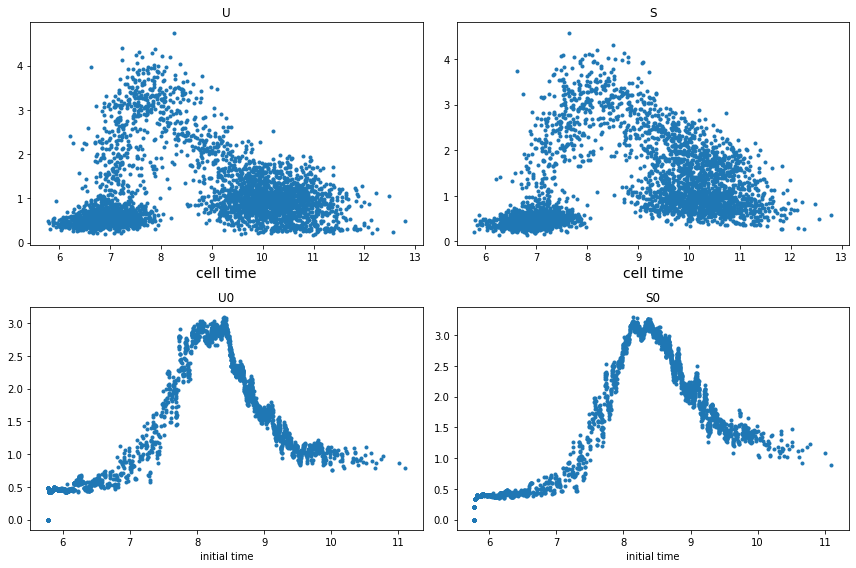

In [11]:
#Plot a gene before training
name='Ppp3ca'
gidx = np.where(adata.var_names==name)[0][0]
#gidx = 203
name = adata.var_names[gidx]
u = adata.layers['Mu'][:, gidx]
s = adata.layers['Ms'][:, gidx]
#Sanity check
fig, ax = plt.subplots(2,2,figsize=(12,8))
ax[0,0].plot(t,u,'.')
ax[0,0].set_xlabel('cell time', fontsize=14)
ax[0,0].set_title('U')

ax[0,1].plot(t,s,'.')
ax[0,1].set_title('S')
ax[0,1].set_xlabel('cell time', fontsize=14)

ax[1,0].plot(t0,u0[:,gidx],'.')
ax[1,0].set_xlabel('initial time')
ax[1,0].set_title('U0')

ax[1,1].plot(t0,s0[:,gidx],'.')
ax[1,1].set_xlabel('initial time')
ax[1,1].set_title('S0')
plt.tight_layout()
plt.show(fig)
#fig.savefig(figure_path+'/sanity.png')

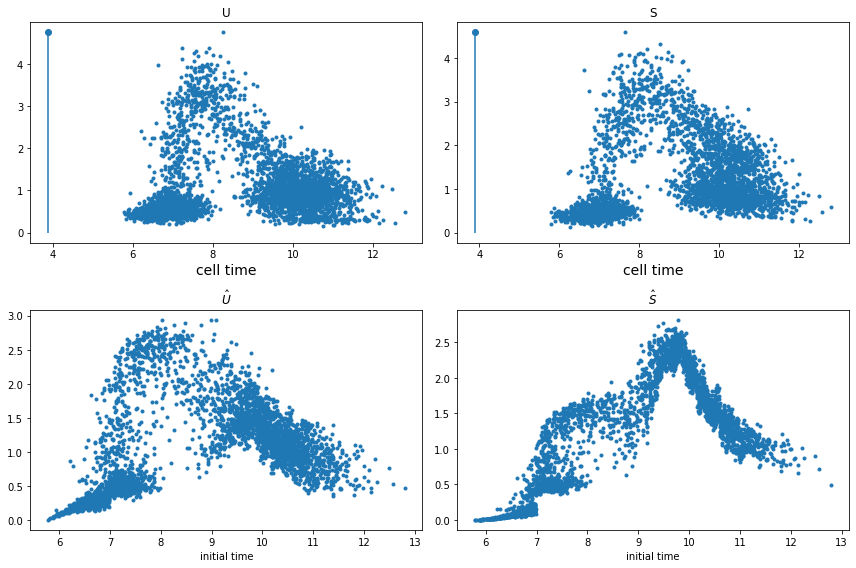

In [13]:
fig, ax = plt.subplots(2,2,figsize=(12,8))
ax[0,0].plot(t,u,'.')
ax[0,0].set_xlabel('cell time', fontsize=14)
ax[0,0].set_title('U')
ax[0,0].stem([ton[gidx]],[u.max()])

ax[0,1].plot(t,s,'.')
ax[0,1].set_title('S')
ax[0,1].set_xlabel('cell time', fontsize=14)
ax[0,1].stem([ton[gidx]],[s.max()])

ax[1,0].plot(t,Uhat_init[:,gidx],'.')
ax[1,0].set_xlabel('initial time')
ax[1,0].set_title(r'$\hat{U}$')

ax[1,1].plot(t,Shat_init[:,gidx],'.')
ax[1,1].set_xlabel('initial time')
ax[1,1].set_title(r'$\hat{S}$')
plt.tight_layout()
plt.show(fig)
fig.savefig(figure_path+f'/{name}_init.png')

1828


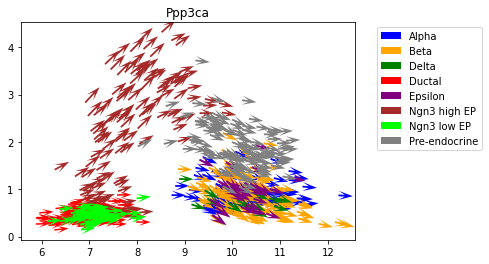

In [14]:
cell_labels = adata.obs.clusters.to_numpy()
cell_types = np.unique(cell_labels)
v = beta[gidx] * Uhat_init[:, gidx] / scaling[gidx] - gamma[gidx] * Shat_init[:, gidx]

dt = 0.2
s_ = s + v*dt
print(np.sum(s_-s<0))
fig, ax = plt.subplots()
#ax.plot(t, s, '.', label='s')
#ax.plot(t, s_, '.', label='s+v*dt')
for i,x in enumerate(cell_types):
    ax.quiver(t[cell_labels==x][::5], s[cell_labels==x][::5], dt*np.ones((len(t[cell_labels==x][::5]))), v[cell_labels==x][::5]*dt, angles='xy', scale=1.0, scale_units='inches', headwidth=5.0, headlength=8.0, color=colors[i], label=x)
ax.set_title(name)
ax.legend(bbox_to_anchor=(1.05,1.0), loc='upper left')
fig.show()
fig.savefig(figure_path+f'/{name}_{key}_vel_init.png', bbox_inches='tight')

In [ ]:
#Training
loss_list = []
N_epoch = 200
for epoch in range(N_epoch):
    iterX = iter(data_loader)
    B = len(iterX)
    for i in range(B):
        optimizer.zero_grad()
        batch = iterX.next()
        xbatch, idx = batch[0], batch[1]
        u_batch = xbatch[:,:xbatch.shape[1]//2].to(device)
        s_batch = xbatch[:,xbatch.shape[1]//2:].to(device)
        
        uhat, shat = predSU(F.relu(t_ts[idx]-t0_ts[idx]), u0_ts[idx], s0_ts[idx], alpha_ts.exp()*F.sigmoid(rho_ts[idx]), beta_ts.exp(), gamma_ts.exp(), scaling_ts)

        loss = (((u_batch-uhat)/sigma_u_ts).pow(2)+((s_batch-shat)/sigma_s_ts).pow(2)).sum(1).mean()

        loss_list.append(loss.detach().cpu().item())
        with torch.autograd.detect_anomaly():
            loss.backward()
        optimizer.step()
    if((epoch+1) % 50 == 0):
        print(loss)
        

In [ ]:
Uhat, Shat = predSU(F.relu(t_ts-t0_ts), u0_ts, s0_ts, alpha_ts.exp()*F.sigmoid(rho_ts), beta_ts.exp(), gamma_ts.exp(), scaling_ts)
Uhat = Uhat.detach().cpu().numpy()
Shat = Shat.detach().cpu().numpy()

In [ ]:
#Result
u = adata.layers['Mu'][:, gidx]
s = adata.layers['Ms'][:, gidx]
fig, ax = plt.subplots(2,2,figsize=(12,8))
ax[0,0].plot(t,u,'.')
ax[0,0].set_xlabel('cell time', fontsize=14)
ax[0,0].set_title('U')

ax[0,1].plot(t,s,'.')
ax[0,1].set_title('S')
ax[0,1].set_xlabel('cell time', fontsize=14)

ax[1,0].plot(t,Uhat[:,gidx],'.')
ax[1,0].set_xlabel('initial time')
ax[1,0].set_title(r'$\hat{U}$')

ax[1,1].plot(t,Shat[:,gidx],'.')
ax[1,1].set_xlabel('initial time')
ax[1,1].set_title(r'$\hat{S}$')
plt.tight_layout()
plt.show(fig)
fig.savefig(figure_path+f'/{name}.png')

In [ ]:
cell_labels = adata.obs.clusters.to_numpy()
cell_types = np.unique(cell_labels)
v = beta_ts[gidx].detach().cpu().item() * Uhat[:, gidx]/scaling[gidx] - gamma_ts[gidx].detach().cpu().item() * Shat[:, gidx]

dt = 0.2
s_ = s + v*dt
print(np.sum(s_-s<0))
fig, ax = plt.subplots()
#ax.plot(t, s, '.', label='s')
#ax.plot(t, s_, '.', label='s+v*dt')
for i,x in enumerate(cell_types):
    ax.quiver(t[cell_labels==x][::10], s[cell_labels==x][::10], dt*np.ones((len(t[cell_labels==x][::10]))), v[cell_labels==x][::10]*dt, angles='xy', scale=1.0, scale_units='inches', headwidth=5.0, headlength=8.0, color=colors[i], label=x)
ax.set_title(name)
ax.legend(bbox_to_anchor=(1.05,1.0), loc='upper left')
fig.show()
fig.savefig(figure_path+f'/{name}_{key}_vel.png', bbox_inches='tight')

In [15]:
V = (beta_ts.detach().cpu().numpy() * Uhat_init/scaling - gamma_ts.detach().cpu().numpy() * Shat_init) * (t.reshape(-1,1)>=ton)
adata.layers["test_velocity"] = V

computing velocity graph (using 1/40 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:33) --> added 
    'test_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'test_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ../figures/Pancreas/Rho2/brain_vanillappvel.png


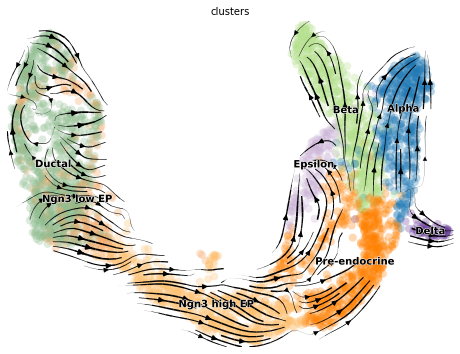

In [16]:
scv.tl.velocity_graph(adata, vkey=f'test_velocity')
scv.tl.velocity_embedding(adata, vkey=f'test_velocity')
scv.pl.velocity_embedding_stream(adata, vkey=f'test_velocity', figsize=(8,6), save=figure_path+f'/brain_{key}vel.png')